In [1]:
import rpyc
import numpy as np
import winsound
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
# m = motor.LargeMotor('outA')
# m.run_timed(time_sp=1000, speed_sp=-1050)

In [39]:
def get_motors_and_sensor(motor, sensor):
    cs = sensor.ColorSensor()
    ts1 = sensor.TouchSensor('in1')
    ts2 = sensor.TouchSensor('in2')
    bot = motor.MediumMotor('outA')
    top = motor.MediumMotor('outB')
    return top, bot, cs, ts1, ts2

def record_scan_path():
    top_l = []
    bot_l = []
    top.reset(), bot.reset()
    winsound.Beep(400, 500)
    winsound.Beep(400, 500)
    winsound.Beep(600, 500)
    while(ts1.value() == 0):
        while(ts2.value() == 0):
            pass
        top_p, bot_p = top.position, bot.position
        print(top.position, bot.position)
        top_l.append(top_p)
        bot_l.append(bot_p)
    return _clip_instructions(top_l, bot_l)

def _clip_instructions(top_l, bot_l):
    prev_t, prev_b = top_l[0], bot_l[0]
    remove_front = 0
    for t, b in zip(top_l, bot_l):
        if t == prev_t and b == prev_b:
            remove_front += 1        
        else:
            break
            
    prev_t, prev_b = top_l[-1], bot_l[-1]
    remove_back = 0
    for t, b in zip(reversed(top_l), reversed(bot_l)):
        if t == prev_t and b == prev_b:
            remove_back += 1        
        else:
            break
    
    first = remove_front - 1
    if first < 0:
        first = 0
    last = -remove_back + 1
    if last >= 0:
        last = None
    
    return top_l[first:last], bot_l[first:last]

In [40]:
# bot.run_timed(time_sp=250, speed_sp=100)
# top.run_timed(time_sp=250, speed_sp=100)

In [41]:
conn = rpyc.classic.connect('169.254.139.173')
top, bot, cs, ts1, ts2 = get_motors_and_sensor(conn.modules['ev3dev2.motor'], conn.modules['ev3dev2.sensor.lego'])

In [42]:
top_l, bot_l = record_scan_path()

16 -21
0 -51
16 2
-7 -28
11 10
-15 -5
18 27
-16 19
21 34
-15 34
11 48
-12 48
6 48
24 62
-4 70
-12 49
14 28
14 15
-15 15
-15 2
16 2
11 -14
-5 -33
11 -33
-1 16
-1 16


In [71]:
np.save('top_l.npy', top_l)
np.save('bot_l.npy', bot_l)

In [43]:
top_l, bot_l = np.load('top_l.npy'), np.load('bot_l.npy')

[-21,
 -51,
 2,
 -28,
 10,
 -5,
 27,
 19,
 34,
 34,
 48,
 48,
 48,
 62,
 70,
 49,
 28,
 15,
 15,
 2,
 2,
 -14,
 -33,
 -33,
 16]

In [93]:
top.run_to_abs_pos(position_sp=0)
bot.run_to_abs_pos(position_sp=0)

In [45]:
top.stop(), bot.stop(), top.speed_sp

(None, None, 0)

In [80]:
WHITE = (188, 217, 240)

In [84]:
def reset_position():
    top.run_to_abs_pos(position_sp = 0)
    bot.run_to_abs_pos(position_sp = 0)
    if top.wait_until_not_moving(timeout=2000) and bot.wait_until_not_moving(timeout=2000):
        pass

def clip_to_white(rgb):
    def clip_one(value, max_):
        return np.max(value, max_)
    return [(np.max([r, WHITE[0]]), np.max([g, WHITE[1]]), np.max([b, WHITE[2]])) for r,g,b in rgb ]
    
def get_reading(top_l, bot_l, lim_n, timeout=2000):
    reading = []
    for (a, b) in tqdm(zip(top_l[:lim_n],bot_l[:lim_n])):
        reading.append(cs.raw)
        reading.append(cs.raw)
        bot.run_to_abs_pos(position_sp = b)
        reading.append(cs.raw)
        reading.append(cs.raw)
        top.run_to_abs_pos(position_sp = a)
        reading.append(cs.raw)
        reading.append(cs.raw)
        if top.wait_until_not_moving(timeout=timeout) and bot.wait_until_not_moving(timeout=timeout):
            pass
        reading.append(cs.raw)
        reading.append(cs.raw)
    return clip_to_white(reading)

def perform_readings(top_l, bot_l, n_runs=1, lim_n=None, speed=100):
    top.speed_sp, bot.speed_sp = [speed] * 2
    readings = []
    for _ in range(n_runs):
        reset_position()
        reading = get_reading(top_l, bot_l, lim_n)
        readings.append(reading)
    return np.squeeze(np.array(readings))

def get_rgb_mean_from_multiple_readings(readings):
    return get_rgb(np.mean(readings, axis=0))

def get_rgb(rgb):
    return np.split(rgb, indices_or_sections=3, axis=1)

def plot_rgb(r,g,b):
    plt.plot(r, 'red')
    plt.plot(g, 'green')
    plt.plot(b, 'blue')
    plt.show()

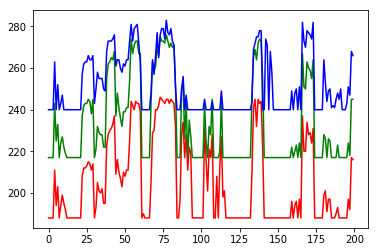

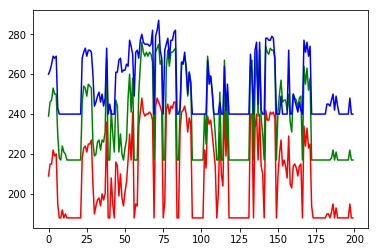

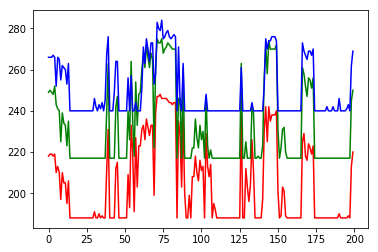

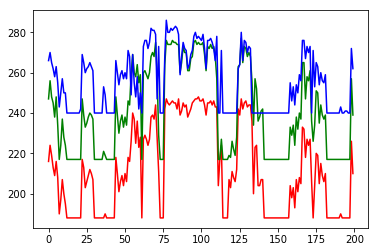

In [91]:
max_readings = 4
readings = []
stop_flag = False
for _ in range(max_readings):
    while(ts1.value() == 0):
        if(ts2.value() == 1):
            stop_flag = True
            break
        pass
    if stop_flag:
        break
    
    reading = perform_readings(top_l[::], bot_l[::], n_runs=1, lim_n=None, speed=50)
    plot_rgb(*get_rgb(reading))
    readings.append(reading)

In [92]:
np.save('triangle_rotated.npy', readings)

In [82]:
max_readings = 3
stop_flag = False
for _ in range(max_readings):
    while(ts1.value() == 0):
        if(ts2.value() == 1):
            stop_flag = True
            break
        pass
    if stop_flag:
        break
    
    reading = perform_readings(top_l[::], bot_l[::], n_runs=1, lim_n=None, speed=50)
    plot_rgb(*get_rgb(reading))

KeyboardInterrupt: 

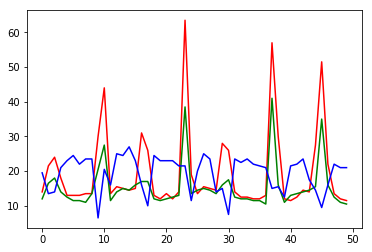

In [797]:
plot_rgb(*get_rgb_mean_from_multiple_readings(banana))

In [33]:
dir(top)

['COMMAND_RESET',
 'COMMAND_RUN_DIRECT',
 'COMMAND_RUN_FOREVER',
 'COMMAND_RUN_TIMED',
 'COMMAND_RUN_TO_ABS_POS',
 'COMMAND_RUN_TO_REL_POS',
 'COMMAND_STOP',
 'DEVICE_ROOT_PATH',
 'ENCODER_POLARITY_INVERSED',
 'ENCODER_POLARITY_NORMAL',
 'POLARITY_INVERSED',
 'POLARITY_NORMAL',
 'STATE_HOLDING',
 'STATE_OVERLOADED',
 'STATE_RAMPING',
 'STATE_RUNNING',
 'STATE_STALLED',
 'STOP_ACTION_BRAKE',
 'STOP_ACTION_COAST',
 'STOP_ACTION_HOLD',
 'SYSTEM_CLASS_NAME',
 'SYSTEM_DEVICE_NAME_CONVENTION',
 '_DEVICE_INDEX',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_address',
 '_attribute_file_open',
 '_command',
 '_commands',
 '_count_per_m',
 '_count_per_rot',
 '_device_index',
 '_driver_name',
 '_duty_cycle',
 '_d

In [58]:
top.on_to_position?

In [43]:
top.reset?

In [137]:
top.reset(), bot.reset()

(None, None)